In [12]:
import pandas as pd

# Load the dataset
df = pd.read_csv('spotify_dataset.csv')

In [13]:
# TO CHECK IF THE INPUT SONG EXISTS

def check_song_availability(track_name, artist_name):
    # Convert input song details to lowercase for case-insensitive comparison
    track_name_lower = track_name.strip().lower()
    artist_name_lower = artist_name.strip().lower()
    
    # Check if the song exists in the dataset
    song = df[(df['track_name'].str.lower() == track_name_lower) & 
              (df['artists'].str.lower().str.contains(artist_name_lower))]
    
    if song.empty:
        print(f"Song '{track_name}' by '{artist_name}' was NOT found in the dataset.")
        return None
    else:
        print(f"YES, Song '{track_name}' by '{artist_name}' was found in the dataset.")

# Get user input
track_name = input("Enter the track name: ").strip()
artist_name = input("Enter the artist name(s): ").strip()

input_song = {
    'track_name': track_name,
    'artist_name': artist_name
}

# Check if the song is available in the dataset
check_song_availability(track_name, artist_name)



Enter the track name:  blank space
Enter the artist name(s):  Taylor swift


YES, Song 'blank space' by 'Taylor swift' was found in the dataset.


In [14]:
# Step 1: Unsupervised Learning: K-means Clustering

In [15]:
# MODEL

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans

class KMeansSongRecommender:
    def __init__(self, n_clusters=None):
        self.n_clusters = n_clusters
        self.label_encoder = LabelEncoder()
        self.scaler = StandardScaler()
        self.kmeans = None

    def preprocess_data(self, df):
        df = df.dropna()
        df = df.drop(['time_signature', 'key'], axis=1)
        df.drop_duplicates(subset=['track_id'], inplace=True)
        df['track_genre_encoded'] = self.label_encoder.fit_transform(df['track_genre'].astype(str))
        
        features = ['track_genre_encoded', 'danceability', 'energy', 'valence', 'loudness',
                    'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'tempo']
        df_features = df[features]
        
        df_features_normalized = self.scaler.fit_transform(df_features)
        
        return df, df_features_normalized

    def fit(self, df):
        df, df_features_normalized = self.preprocess_data(df)
        
        if not self.n_clusters:
            self.n_clusters = len(df['track_genre'].unique())
        
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=0)
        df['cluster'] = self.kmeans.fit_predict(df_features_normalized)
        
        return df

    def recommend(self, df, input_song, n_recommendations=5):
        input_song_name = input_song['track_name'].strip().lower()
        input_artist_name = input_song['artist_name'].strip().lower()
        
        song = df[(df['track_name'].str.lower() == input_song_name) & 
                  (df['artists'].apply(lambda x: any(artist.lower() == input_artist_name for artist in x.lower().split(';'))))]
        
        if song.empty:
            return "Input song not found in the dataset."
        
        cluster = song['cluster'].values[0]
        similar_songs = df[df['cluster'] == cluster]
        similar_songs = similar_songs[~similar_songs['track_name'].str.lower().isin([input_song_name])]
        unique_recommendations = similar_songs.drop_duplicates(subset='track_name')
        unique_recommendations = unique_recommendations.sort_values(by='popularity', ascending=False)
        
        recommendations_df = unique_recommendations.head(n_recommendations)
        
        if not recommendations_df.empty:
            return recommendations_df[['track_name', 'artists']]
        else:
            return "No recommendations found for the input song's cluster."


In [16]:
recommender = KMeansSongRecommender()
df = recommender.fit(df)
recommendations = recommender.recommend(df, input_song, n_recommendations=5)
print(recommendations)

                                     track_name                      artists
67801                                    LOKERA  Rauw Alejandro;Lyanno;Brray
51352                           About Damn Time                        Lizzo
38004  Why'd You Only Call Me When You're High?               Arctic Monkeys
51159                                Without Me                       Eminem
51216                       The Real Slim Shady                       Eminem


In [17]:
# Step 2: Supervised Learning: Content-Based Filtering

In [18]:
# MODEL

from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

class ContentBasedRecommender:
    def __init__(self, features):
        self.features = features
        self.scaler = StandardScaler()
        self.X_normalized = None

    def preprocess_data(self, df):
        self.df_reset = df.reset_index(drop=True)
        self.df_reset['artists'] = self.df_reset['artists'].fillna('').astype(str)  # Handle missing artist values
        self.X_normalized = self.scaler.fit_transform(self.df_reset[self.features])

    def recommend(self, input_song, num_recommendations=5):
        input_song_name = input_song['track_name'].strip().lower()
        input_artist_name = input_song['artist_name'].strip().lower()
        
        song = self.df_reset[(self.df_reset['track_name'].str.lower() == input_song_name) & 
                             (self.df_reset['artists'].apply(lambda x: any(artist.lower() == input_artist_name for artist in x.split(';'))))]
        
        if song.empty:
            return "Input song not found in the dataset."
        
        input_index = song.index[0]
        input_features = self.X_normalized[input_index].reshape(1, -1)
        similarities = cosine_similarity(input_features, self.X_normalized)
        
        similarity_df = pd.DataFrame(similarities.T, index=self.df_reset.index, columns=['similarity'])
        similarity_df = similarity_df.drop(index=input_index)
        
        recommendations = similarity_df.sort_values(by='similarity', ascending=False).head(num_recommendations * 2).join(self.df_reset[['track_name', 'artists']])
        recommendations = recommendations.drop_duplicates(subset='track_name')
        recommendations = recommendations[~(recommendations['track_name'].str.lower() == input_song_name) & 
                                          ~(recommendations['artists'].apply(lambda x: any(artist.lower() == input_artist_name for artist in x.split(';'))))]
        
        recommendations = recommendations.head(num_recommendations)
        
        return recommendations if not recommendations.empty else "No recommendations found."
        

In [19]:
features = ['danceability', 'energy', 'valence', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'tempo']
recommender = ContentBasedRecommender(features)
recommender.preprocess_data(df)
recommendations = recommender.recommend(input_song, num_recommendations=5)
print(recommendations)

       similarity                                         track_name  \
19711    0.991531                               Loco Contigo - REMIX   
29400    0.991419  Loco Contigo (with J. Balvin & Ozuna feat. Nic...   
32929    0.990431                                              Askim   
58662    0.988703                                             Senjuu   
57357    0.988462                                      Una Noche Más   

                                                 artists  
19711  DJ Snake;J Balvin;Ozuna;Nicky Jam;Natti Natash...  
29400  DJ Snake;J Balvin;Ozuna;Nicky Jam;Natti Natash...  
32929                                   Soolking;Reynmen  
58662                           Havoc Mathan;Havoc Naven  
57357                                     Mariah Angeliq  


In [20]:
# HYBRID MODEL

In [23]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

class HybridSongRecommender:
    def __init__(self, n_clusters=None):
        self.n_clusters = n_clusters
        self.label_encoder = LabelEncoder()
        self.genre_scaler = StandardScaler()
        self.content_scaler = StandardScaler()
        self.kmeans = None
        self.df = None
        self.df_content_features_normalized = None

    def preprocess_data(self, df):
        self.df = df.dropna()
        self.df = self.df.drop_duplicates(subset=['track_id'])
        
        # Encode the genre column
        self.df['track_genre_encoded'] = self.label_encoder.fit_transform(self.df['track_genre'].astype(str))
        
        # Normalize genre features for K-Means clustering
        genre_features = ['track_genre_encoded']
        df_genre_features_normalized = self.genre_scaler.fit_transform(self.df[genre_features])
        
        # Normalize content features for content-based filtering
        content_features = ['danceability', 'energy', 'valence', 'loudness', 
                            'speechiness', 'acousticness', 'instrumentalness', 
                            'liveness', 'tempo']
        self.df_content_features_normalized = self.content_scaler.fit_transform(self.df[content_features])
        
        return df_genre_features_normalized

    def fit(self, df):
        df_genre_features_normalized = self.preprocess_data(df)
        
        if not self.n_clusters:
            self.n_clusters = len(self.df['track_genre'].unique())
        
        # Perform K-Means clustering
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=0)
        self.df['cluster'] = self.kmeans.fit_predict(df_genre_features_normalized)
        
        return self.df

    def recommend(self, input_song, num_recommendations=5):
        input_song_name = input_song['track_name'].strip().lower()
        input_artist_name = input_song['artist_name'].strip().lower()
        
        # Find the input song in the dataset
        song = self.df[(self.df['track_name'].str.lower() == input_song_name) & 
                       (self.df['artists'].str.lower().str.contains(input_artist_name))]
        
        if song.empty:
            return "Input song not found in the dataset."
        
        # Get the cluster of the input song
        cluster = song['cluster'].values[0]
        
        # Get songs within the same cluster
        cluster_songs = self.df[self.df['cluster'] == cluster]
        cluster_songs = cluster_songs[~cluster_songs['track_name'].str.lower().isin([input_song_name])]
        
        # Get the features of the input song
        input_song_position_index = song.index[0]
        input_features = self.df_content_features_normalized[input_song_position_index].reshape(1, -1)
        
        # Get features of the songs in the same cluster
        cluster_songs_features = self.df_content_features_normalized[cluster_songs.index]
        
        # Calculate cosine similarity
        similarities = cosine_similarity(input_features, cluster_songs_features)
        
        # Create a DataFrame of similarities
        similarity_df = pd.DataFrame(similarities.T, index=cluster_songs.index, columns=['similarity'])
        
        # Join with cluster songs and sort by similarity
        recommendations = similarity_df.sort_values(by='similarity', ascending=False).join(cluster_songs[['track_name', 'artists', 'track_genre']])
        
        # Drop duplicates and select top N recommendations
        recommendations = recommendations.drop_duplicates(subset=['track_name', 'artists']).head(num_recommendations)
        
        return recommendations[['track_name', 'artists', 'track_genre']] if not recommendations.empty else "No recommendations found."



In [24]:
df = pd.read_csv('spotify_dataset.csv')
recommender = HybridSongRecommender()
df = recommender.fit(df)
recommendations = recommender.recommend(input_song, num_recommendations=5)
print(recommendations)


                                   track_name        artists track_genre
81135                         Blinding Lights     The Weeknd         pop
81334                               Mistletoe  Justin Bieber         pop
81893                          Blue Banisters   Lana Del Rey         pop
81830  Have Yourself A Merry Little Christmas      Sam Smith         pop
81676                              Black Life  Navaan Sandhu         pop


In [26]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Assuming you have the class imported as HybridSongRecommender

# Initialize the recommender
recommender = HybridSongRecommender()

# Load your dataset
df = pd.read_csv('spotify_dataset.csv')  # Replace with your dataset path

# Preprocess the data (encoding and normalization)
df_genre_features_normalized = recommender.preprocess_data(df)


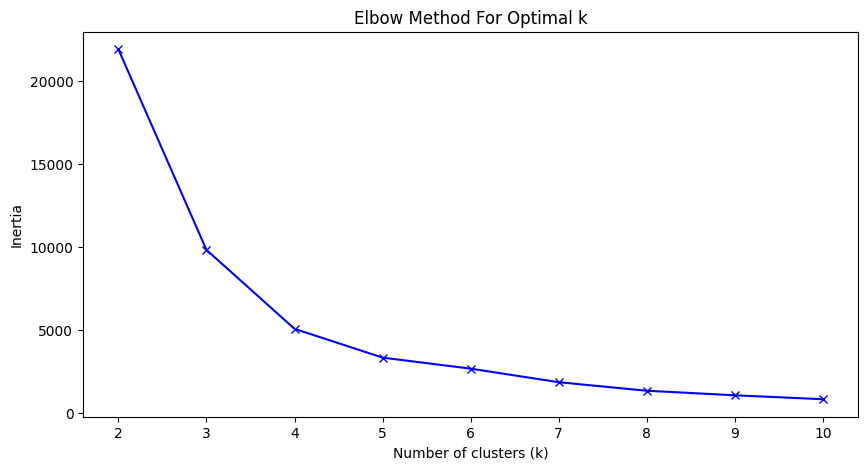

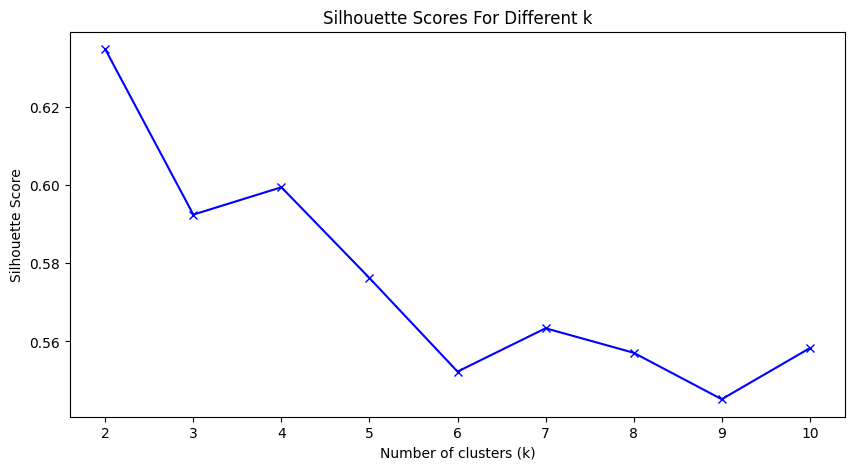

In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def evaluate_clusters(data, max_k):
    inertia = []
    silhouette_scores = []
    
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        cluster_labels = kmeans.fit_predict(data)
        inertia.append(kmeans.inertia_)
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        
    # Plot the Elbow Method
    plt.figure(figsize=(10, 5))
    plt.plot(range(2, max_k + 1), inertia, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal k')
    plt.show()
    
    # Plot the Silhouette Scores
    plt.figure(figsize=(10, 5))
    plt.plot(range(2, max_k + 1), silhouette_scores, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Scores For Different k')
    plt.show()
    
    return inertia, silhouette_scores

n_clusters = len(self.df['track_genre'].unique())
# Evaluate clusters
inertia, silhouette_scores = evaluate_clusters(df_genre_features_normalized, max_k=n_clusters)
